# Introduction

Members: Charles, Clarence, Daeren, Jay (Data Busters)

Dataset Information: The dataset contains 1338 data points with 7 columns. The "charges" column is the response variable while there are 6 other columns acting as the features.

The models that we have selected for this dataset are
1. Linear Regression (Regular, Ridge, Lasso, ElasticNet, Polynomial & Rule-Based)
2. Random Forest
3. Extremely Randomised Trees (Extra Trees)
4. XGBoost
5. CatBoost
6. LightGBM

We have concluded that the best model is CatBoost as it gave the lowest MAE for test data. However, it is also the most volatile in predictions. For a safer alternative, XGBoost has a good balance of prediction accuracy and stability. Both models are highly scalable, supporting periodic retraining as new data streams in.

# Setting Up

Importing / Installing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from itertools import combinations
from lightgbm import LGBMRegressor
from scipy import stats
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

!pip install catboost
from catboost import CatBoostRegressor

Connecting to Google Drive

In [ ]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Importing Dataset

In [ ]:
dataset = "/content/drive/MyDrive/SDS Mini Hackathon 2025 Sem 1/insurance.csv" # Update path accordingly
df = pd.read_csv(dataset)

# Exploratory Data Analysis (EDA)

In [ ]:
# Shows first 5 rows
df.head()

From the code below, it is clear that there are no missing values since the number of non-null values coincide with the number of rows for each column.

In [ ]:
# Summary of Dataframe
df.info()

A visual inspection of the unique elements in each column reveals no irregular entries (such as negative values). There is no need for data cleaning in terms of changing values.

In [ ]:
for col in df.columns:
  print(col)
  print(df[col].unique())
  print()

## Univariate Analysis


### Quantitative Variables

**Features**
- Age Range = 18 to 64 (Average = 39)
- BMI Range = 15.96 to 53.13 (Average = 30.66)
- Children Range = 0 to 5 (Average = 1.09)

**Response**
- Charges Range = 1121.87 to 63770.43 (Average = 13270.42)

In [ ]:
df.describe(include="number")

**Observation**

We can visualise the statistics above with a boxplot. From the plot, there is a significant number of large outliers for the response variable. The majority of people in this dataset have 0-2 children.

In [ ]:
# Sets style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create plots
quantitative = ["age", "bmi", "children", "charges"]
n_col = len(quantitative)
n_rows = (n_col + 1) // 2  # 2 columns per row

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
axes = axes.flatten() if n_col > 1 else [axes]

for id, col in enumerate(quantitative):
  ax = axes[id]

  # Create box plot
  bp = ax.boxplot([df[col].dropna()], vert=True, widths=0.5, patch_artist=True,
                   showmeans=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2),
                   meanprops=dict(color='green', marker='D', markerfacecolor='green', markersize=8))

  ax.set_ylabel(col)
  ax.set_title(f'Box plot of {col}', fontsize=14)
  ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

We will generate a histogram for each of the variables above.

In [ ]:
# Sets style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create histogram for distribution of quantitative variables
quantitative = ["age", "bmi", "children", "charges"]
n_col = len(quantitative)
n_rows = (n_col + 1) // 2  # 2 columns per row

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
axes = axes.flatten() if n_col > 1 else [axes]

for id, col in enumerate(quantitative):
  ax = axes[id]
  ax.hist(df[col], bins=20, edgecolor="black", alpha=0.7)

  # Add mean / median lines
  mean_val = df[col].mean()
  median_val = df[col].median()
  ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
  ax.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

  ax.set_xlabel(col)
  ax.set_ylabel('Frequency')
  ax.set_title(f'Distribution of {col}')
  ax.legend()

plt.tight_layout()
plt.show()

**Observation**

The response variable has a right-skewed distribution while bmi has a normal distribution. There are many more 18/19 year olds in this dataset, relative to the other age groups. Since the feature "children" has 6 discrete values, we will investigate it as a possibly categorical variable.

### Categorical Variables

In [ ]:
# Checking counts of each category
for col in ["sex", "smoker", "region", "children"]:
  print(df[col].value_counts())
  print()
  print(df[col].value_counts(normalize=True) * 100)
  print("-----------------------------------" + "\n")

**Observation**

From investigating the categorical variables, the dataset is shown to have around the same number of males and females, and a generally even distribution of people coming from all 4 regions. There are also very few people with at least 4 children covered by health insurance (3.21%). The dataset also contains about 4 times as many non-smokers than smokers.

## Bivariate Analysis


### Quantitative Variables vs Response

In [ ]:
# Sets style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create plots
quantitative = ["age", "bmi"] # excludes children since the values are discrete so correlation is low
n_col = len(quantitative)
n_rows = (n_col + 1) // 2  # 2 columns per row

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
axes = axes.flatten() if n_col > 1 else [axes]

for id, col in enumerate(quantitative):
  ax = axes[id]

  # Create scatter plot
  ax.scatter(df[col], df["charges"],
             alpha=0.5, s=30, edgecolors='black',
             linewidths=0.5)

  # Add regression line
  x = df[col]
  y = df["charges"]
  z = np.polyfit(x, y, 1)  # fit a polynomial of degree 1
  p = np.poly1d(z)         # creates polynomial line that best fits data
  ax.plot(x, p(x), "r--", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')

  # Calculate correlation
  corr, p_value = pearsonr(df[col], df["charges"])

  ax.set_xlabel(col, fontsize=11, fontweight='bold')
  ax.set_ylabel("charges", fontsize=11, fontweight='bold')
  ax.set_title(f'{"charges"} vs {col}\nCorr={corr:.3f}, p={p_value:.4f}',
               fontsize=12, fontweight='bold')
  ax.legend()
  ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Observation**

All quantitative variables have low correlation with the response variable ("charges"), with age having the higher correlation of 0.299.

### Categorical Variables vs Response

In [ ]:
# Sets style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create box plots
categorical = ["sex", "smoker", "region", "children"]
n_col = len(categorical)
n_rows = (n_col + 1) // 2  # 2 columns per row

fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4*n_rows))
axes = axes.flatten() if n_col > 1 else [axes]

for id, col in enumerate(categorical):
  ax = axes[id]
  sns.boxplot(x=col, y="charges", data=df, ax=ax)
  ax.set_xlabel(col)
  ax.set_ylabel('Charges')
  ax.set_title(f'Distribution of Charges by {col}')

plt.tight_layout()
plt.show()

**Observation**

From the plot above, only the categories in the column "smoker" have the median line of their categories fall outside the IQR of all other categories. This suggests that the effect of whether a person is a smoker or not is clearly significant in determining their insurance charges. We will investigate this in depth under further EDA.

People in the southeast appear to have a higher charges in general, as it has the largest charge at the 75th percentile, and largest range of values.

### Analysis between features

#### BMI
Although we have understood that the mean BMI is about 30.66 and BMI has low correlation with the response variable, we can convert them into categories. One use case of this is to determine if there are more obese people in certain categories of other features.

In [ ]:
conditions = [
    df['bmi'] < 18.5,
    (df['bmi'] >= 18.5) & (df['bmi'] < 25),
    (df['bmi'] >= 25) & (df['bmi'] < 30),
    (df['bmi'] >= 30) & (df['bmi'] < 35),
    df['bmi'] >= 35
]

labels = ["underweight", "normal", "overweight", "obese", "extremely_obese"]

# Create dataset with bmi categories, dropping bmi
df_modified = df.copy()
df_modified["bmi category"] = np.select(conditions, labels, default="unknown")

# Order BMI categories correctly
df_modified["bmi category"] = pd.Categorical(
    df_modified["bmi category"],
    categories=labels,
    ordered=True
)

df_modified = df_modified.drop(columns=["bmi"])
print(df_modified.head())

The high count of overweight to extremely obese people tallies with the high mean BMI.

In [ ]:
# No. of people in each bmi category
print(df_modified["bmi category"].value_counts())

We will create a plot of the BMI categories across various features.

In [ ]:
variables = ["sex", "smoker", "region", "children"]

n_rows = (len(variables) + 1) // 2

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 10))
axes = axes.flatten()

bmi_order = ['underweight', 'normal', 'overweight', 'obese', 'extremely_obese']

for idx, col in enumerate(variables):
    crosstab = pd.crosstab(df_modified['bmi category'], df_modified[col]).reindex(bmi_order)

    crosstab.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'{col} distribution across bmi category')
    axes[idx].set_xlabel("BMI Category")
    axes[idx].set_ylabel("Count")
    axes[idx].legend(title=f"{col}", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Observation**

From here, we can tell that the southeast has significantly more extremely obese people. This suggests that people in the southeast may have a higher risk of health problems.

In [ ]:
variables = ["sex", "smoker", "region", "children"]

n_rows = (len(variables) + 1) // 2

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 10))
axes = axes.flatten()

bmi_order = ['underweight', 'normal', 'overweight', 'obese', 'extremely_obese']

for idx, col in enumerate(variables):
    crosstab = pd.crosstab(df_modified['bmi category'], df_modified[col]).reindex(bmi_order)

    # Convert to percentage
    crosstab_pct = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

    crosstab_pct.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'{col} distribution across bmi category')
    axes[idx].set_xlabel("BMI Category")
    axes[idx].set_ylabel(f"Percentage (%) of {col}")
    axes[idx].legend(title=f"{col}", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylim(0, 50)

plt.tight_layout()
plt.show()

**Observation**

About 47% of people with 4 children are overweight, which is a large proportion. However, there are very few people with 4 children to begin with so this proportion may not represent the real percentage throughout USA.

#### Region

In [ ]:
variables = ["sex", "smoker", "bmi category", "children"]

n_rows = (len(variables) + 1) // 2

fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(12, 10))
axes = axes.flatten()


for idx, col in enumerate(variables):
    crosstab = pd.crosstab(df_modified['region'], df_modified[col])

    crosstab_pct = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

    crosstab_pct.plot(kind='bar', ax=axes[idx], width=0.8)
    axes[idx].set_title(f'{col} distribution across region')
    axes[idx].set_xlabel("Region")
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend(title=f"{col}", bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Observation**

The southeast has a higher proportion of smokers compared to other regions.

Most of the underweight people are in the northeast and northwest while most of the people with 5 children are in the southeast and southwest. However, both groups make up a very small proportion of their categories respectively so these are likely insignificant in explaining any effect on charges.

#### Age

In [ ]:
variables = ["sex", "smoker", "region", "children", "bmi category"]

n_rows = (len(variables) + 1) // 2
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for idx, col in enumerate(variables):
    df_modified.boxplot(column='age', by=col, ax=axes[idx])
    axes[idx].set_title(f'age distribution across {col}')
    axes[idx].set_xlabel(f"{col}")
    axes[idx].set_ylabel("Age")
    axes[idx].get_figure().suptitle('')  # Remove default title

axes[-1].axis('off')

plt.tight_layout()
plt.show()

**Observation**

50% of people with 0 children fall in the age range of 22-55, making this the largest IQR amongst the categories.

The underweight category is small, but 75% of them are people ranging from 18-38 years old. It has the largest proportion of younger people in this dataset. As the IQR moves upwards as we go from underweight to extremely obese, people in this dataset have higher BMIs as they grow older.

## Multivariate Analysis

To obtain a numerical value to quantify the correlation between variables, we will perform one-hot encoding to convert categorical variables to numbers. The results below indeed confirms that the top 3 features with strongest correlation with the response variable are as follows (from top to bottom):
1. Smoker (0.79)
2. Age (0.30)
3. BMI (0.20)

These variables most strongly predict charges in data.

In [ ]:
# One-Hot Encoding (excludes bmi categories)
df_encoded = pd.get_dummies(df, columns=['sex', 'region', 'smoker'],
                            drop_first=True,  # Avoid multicollinearity
                            dtype=int)

# Correlation Matrix
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

**Observation**

People in the southeast pay the most charges in general, although only marginally higher. This also suggests that even though we have seen a high percentage of people who are extremely obese in the southeast, and a low correlation between charges and southeast (0.07), we do not have any factors here in the dataset that suggest a possible reason for the high obesity rate in the southeast.

We will investigate in **Further EDA** if the higher number of extremely obese people in the southeast explains the higher charges in the region.

# Further EDA

## Investigation on smokers & non-smokers

From our exploration above (EDA), we observe that the correlation between smokers & charges is quite high. Let's further explore it!

In [ ]:
# Sets style
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Charges for smokers (smoker_yes = 1)
sns.histplot(
    data=df_encoded[df_encoded.smoker_yes == 1],
    x="charges",
    bins=30,
    kde=True,
    stat="density",
    color="#E74C3C",
    ax=axes[0]
)
axes[0].set_title("Charges Distribution (Smokers)", fontsize=13)
axes[0].set_xlabel("Charges")
axes[0].set_ylabel("Count")

# Charges for non-smokers (smoker_yes = 0)
sns.histplot(
    data=df_encoded[df_encoded.smoker_yes == 0],
    x="charges",
    bins=30,
    kde=True,
    stat="density",
    color="#3498DB",
    ax=axes[1]
)
axes[1].set_title("Charges Distribution (Non-Smokers)", fontsize=13)
axes[1].set_xlabel("Charges")
axes[1].set_ylabel("")


for ax in axes:
    ax.grid(alpha=0.3)
    sns.despine(ax=ax)
plt.suptitle("Insurance Charges by Smoking Status", fontsize=15, y=1.03)

plt.tight_layout()
plt.show()

**Observation**  
Charges for smokers show two distinct peaks, indicating there are two groups of smokers paying different ranges of charges. We will investigate the factors behind this separation.  

For non-smokers, the distribution is right-skewed, with most charges concentrated at the lower end.


In [ ]:
# Plot a scatter plot showing how charges are split by age and smoking status
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df,
    x="age",
    y="charges",
    hue="smoker",
    palette="coolwarm",
    s=80,
    alpha=0.7
)
plt.title("Charges vs Age by Smoking Status")
plt.xlabel("Age")
plt.ylabel("Charges")
plt.legend(title="Smoker")
plt.show()

**Observation**  
Charges tend to increase with age.

There appear to be three distinct regions on the plot, with some overlap between smokers and non-smokers.
***
**Current Hypothesis**  
There may be four groups of people:

- **Group 1:** Non-smokers forming a linear trend with lower charges  
- **Group 2:** Non-smokers whose charges overlap with some smokers  
- **Group 3:** Smokers whose charges overlap with some non-smokers  
- **Group 4:** Smokers with the highest charges  
***
**Next Steps**

1. **Identify similarities between Groups 2 & 3**  
   - Find a trait within the non-smoker group that distinguishes them from Group 1, placing their charges in the same range as some smokers.  
   - Hypothesize that the overlapping smoker group (Group 3) shares this trait, explaining why charges converge in the same region.

2. **Identify differences**  
   - Between the two non-smoking groups  
   - Between the two smoking groups  

We will begin by investigating the two smoker groups to understand what differentiates them.


In [ ]:
# Obtain rows of smokers
smokers_df = df_encoded[df_encoded.smoker_yes == 1].copy()
features = ['age', 'bmi', 'children', 'charges',
            'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']

X = smokers_df[features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use KMeans Clustering to visualise the 2 smoker groups
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
smokers_df['cluster'] = kmeans.fit_predict(X_scaled)

# Add smoker group to df
smokers_df['smoker_group'] = smokers_df['cluster'] + 1

# Plot scatterplot
sns.set(style="whitegrid")
features_to_plot = ['age', 'bmi', 'children']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, feature in zip(axes, features_to_plot):
    sns.scatterplot(
        data=smokers_df,
        x=feature,
        y='charges',
        hue='smoker_group',
        palette='Set1',
        s=80,
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"Charges vs {feature.capitalize()}")
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Charges" if ax==axes[0] else "")
    ax.legend(title="Smoker Group")

plt.tight_layout()
plt.show()

**Observation**

It is clear that the difference in charges between the two smoker groups is largely driven by their BMIs. Smokers with higher BMI have higher insurance charges.

In [ ]:
# Recreate 'region' column
def get_region(row):
    if row['region_northwest'] == 1:
        return 'northwest'
    elif row['region_southeast'] == 1:
        return 'southeast'
    elif row['region_southwest'] == 1:
        return 'southwest'
    else:
        return 'northeast'  # default when all 0

smokers_df['region'] = smokers_df.apply(get_region, axis=1)

# Plot count of smoker groups per region
plt.figure(figsize=(8,5))
sns.countplot(
    data=smokers_df,
    x='region',
    hue='smoker_group',
    palette='Set1'
)
plt.title("Smoker Group Distribution by Region")
plt.xlabel("Region")
plt.ylabel("Number of Smokers")
plt.show()

**Observation**

We observe that the Southeast region has a high concentration of smokers in group 2, which aligns with our earlier EDA findings showing that this group also tends to have higher BMIs. Next, we will investigate the two non-smoker groups.

In [ ]:
# Obtain rows of non-smokers
nonsmokers_df = df_encoded[df_encoded.smoker_yes == 0].copy()
features = ['age', 'bmi', 'children', 'charges',
            'sex_male', 'region_northwest', 'region_southeast', 'region_southwest']

X = nonsmokers_df[features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use KMeans clustering to visualise the two groups
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
nonsmokers_df['cluster'] = kmeans.fit_predict(X_scaled)

# Add smoker group to df
nonsmokers_df['nonsmoker_group'] = smokers_df['cluster'] + 1

features_to_plot = ['age', 'bmi', 'children']

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)  # 1 row, 3 columns

for ax, feature in zip(axes, features_to_plot):
    sns.scatterplot(
        data=nonsmokers_df,
        x=feature,
        y='charges',
        hue='cluster',
        palette='Set1',
        s=80,
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"Charges vs {feature.capitalize()}")
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Charges" if ax==axes[0] else "")  # only leftmost plot has y-label
    ax.legend(title="Cluster")

plt.tight_layout()
plt.show()

**Observation**

Unfortunately, there do not appear to be clear clusters or identifiable factors that separate the two groups. To investigate further, we will explore the possibility that one of the groups simply consists of outliers. For this purpose, we will extract the outliers using the approach of identifying values below LQ − 3×IQR or above UQ + 3×IQR.

In [ ]:
# Function to flag outliers within each age
def age_based_outliers(group, multiplier=3):
    Q1 = group['charges'].quantile(0.25)
    Q3 = group['charges'].quantile(0.75)
    IQR = Q3 - Q1
    # Flag outliers
    return (group['charges'] > Q3 + multiplier*IQR) | (group['charges'] < Q1 - multiplier*IQR)

# Apply per age group
nonsmokers_df['is_outlier'] = nonsmokers_df.groupby('age').apply(age_based_outliers).reset_index(level=0, drop=True)

# Check number of outliers
print(nonsmokers_df['is_outlier'].sum())

In [ ]:
# Sets Style
sns.set(style="whitegrid")
features_to_plot = ['age', 'bmi', 'children']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Scatter plots for identifying outliers
for ax, feature in zip(axes, features_to_plot):
    sns.scatterplot(
        data=nonsmokers_df,
        x=feature,
        y='charges',
        hue='is_outlier',
        palette={True:'red', False:'blue'},
        s=80,
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f"Charges vs {feature.capitalize()} (Non-Smokers)")
    ax.set_xlabel(feature.capitalize())
    ax.set_ylabel("Charges" if ax==axes[0] else "")
    ax.legend(title="Outlier")

plt.tight_layout()
plt.show()

**Summary**

Smokers generally incur higher medical charges than non-smokers, with two subgroups among smokers separated by BMI. Among non-smokers, there is a main group and a set of outliers, likely influenced by factors not captured in the dataset, such as medical history, lifestyle, occupation, genetics, or regional healthcare pricing differences. Overall, charges tend to increase slightly with age as well.

## Investigation on the extremely obese in the southeast & charges

We will investigate if the higher number of extremely obese people explains the higher charges in the southeast.

In [ ]:
print("="*70)
print("Does Southeast's extremely obese population explain higher charges?")
print("="*70)

# Average charges by region
print("\nAVERAGE CHARGES BY REGION:")
overall_charges = df_modified.groupby('region')['charges'].mean()
print(overall_charges.round(2))

# Average charges for extremely obese across regions
print("\nAVERAGE CHARGES FOR EXTREMELY OBESE BY REGION:")
extremely_obese = df_modified[df_modified['bmi category'] == 'extremely_obese']
extremely_obese_charges = extremely_obese.groupby('region')['charges'].mean()
print(extremely_obese_charges.round(2))

# Conduct T-Test (Southeast vs Other Regions for Extremely Obese)
southeast_extra_obese = extremely_obese[extremely_obese['region'] == 'southeast']['charges']
other_extra_obese = extremely_obese[extremely_obese['region'] != 'southeast']['charges']

t_stat, p_value = stats.ttest_ind(southeast_extra_obese, other_extra_obese)

print(f"\nT-TEST (Southeast vs Other Regions - Extremely Obese):")
print(f"Southeast mean: ${southeast_extra_obese.mean():.2f}")
print(f"Others mean: ${other_extra_obese.mean():.2f}")
print(f"Difference: ${southeast_extra_obese.mean() - other_extra_obese.mean():.2f}")
print(f"P-value: {p_value:.4f}")

**Observation**

The southeast still has the highest average charges amongst extremely obese people. Since the p-value = 0.3764 > 0.05, there is no significant difference in average charges between extremely obese people in the southeast versus other regions. Therefore, the higher concentration of extremely obese people in the southeast does not explain regional differences in charges.

It is likely that some other factor is causing this difference in charges. We will investigate if smoking explains this difference in charges since the southeast has a high proportion of smokers.

In [ ]:
# Average charges by region
print("\nAVERAGE CHARGES BY REGION:")
overall_charges = df_modified.groupby('region')['charges'].mean()
print(overall_charges.round(2))

# Average charges for smokers across regions
print("\nAVERAGE CHARGES FOR SMOKER BY REGION:")
smoker = df_modified[df_modified['smoker'] == 'yes']
smoker_charges = smoker.groupby('region')['charges'].mean()
print(extremely_obese_charges.round(2))

# Conduct T-Test (Southeast vs Other Regions for Smokers)
southeast_smoker = smoker[smoker["region"] == "southeast"]["charges"]
other_smoker = smoker[smoker["region"] != "southeast"]["charges"]

t_stat, p_value = stats.ttest_ind(southeast_smoker, other_smoker)

print(f"\nT-TEST (Southeast vs Other Regions - Smoker):")
print(f"Southeast mean: ${southeast_smoker.mean():.2f}")
print(f"Others mean: ${other_smoker.mean():.2f}")
print(f"Difference: ${southeast_smoker.mean() - other_smoker.mean():.2f}")
print(f"P-value: {p_value:.4f}")

**Observation**

Since the p-value = 0.0045 < 0.05, there is significant difference in charges between smokers in Southeast versus the other regions. We conclude that smokers in Southeast have significantly higher insurance charges compared to smokers in other regions.

**Summary**

Smoking is a key factor contributing to Southeast's higher average insurance charges while the higher concentration of extremely obese people is not a key factor.

# Model Training & Evaluation

We will transform some features and engineer new features to achieve better MAE and R^2.

In [ ]:
# Add Interaction Features
df_encoded['smoker_age'] = df_encoded['smoker_yes'] * df_encoded['age']
df_encoded['smoker_bmi'] = df_encoded['smoker_yes'] * df_encoded['bmi']
df_encoded['age_bmi'] = df_encoded['age'] * df_encoded['bmi']

# Add Polynomial Features
df_encoded['age_squared'] = df_encoded['age'] ** 2
df_encoded['bmi_squared'] = df_encoded['bmi'] ** 2

df_encoded.info()

## Linear Regression

In [ ]:
# --- Setup ---
predictor_cols = [col for col in df_encoded.columns if col != target_col]
target_col = 'charges'

X = df_encoded[predictor_cols]
y = np.log(df_encoded[target_col])  # log-transform target

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Linear Regression ---
lm = LinearRegression()

# --- Cross-validation (log-scale model, original-scale MAE) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae_log = []
cv_r2_log = []
cv_mae_orig = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lm.fit(X_tr, y_tr)
    y_val_pred = lm.predict(X_val)

    # Metrics in log scale
    cv_mae_log.append(mean_absolute_error(y_val, y_val_pred))
    cv_r2_log.append(r2_score(y_val, y_val_pred))

    # Convert to original scale for MAE
    y_val_orig = np.exp(y_val)
    y_val_pred_orig = np.exp(y_val_pred)
    cv_mae_orig.append(mean_absolute_error(y_val_orig, y_val_pred_orig))

# --- Final training on full training set ---
lm.fit(X_train, y_train)

# --- Test evaluation ---
y_pred_log = lm.predict(X_test)
test_mae_log = mean_absolute_error(y_test, y_pred_log)
test_r2 = r2_score(y_test, y_pred_log)

# Convert back to original scale
y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred_log)
test_mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)

# --- Results ---
print("Full Linear Regression Model Performance:")
print(f"Features: {predictor_cols}")
print(f"CV MAE: {np.mean(cv_mae_orig):,.2f}")
print(f"CV R²: {np.mean(cv_r2_log):.3f}")
print(f"Test MAE: {test_mae_orig:,.2f}")
print(f"Test R²: {test_r2:.3f}")

# --- Feature importance ---
feature_importance = pd.DataFrame({
    'feature': predictor_cols,
    'coefficient': lm.coef_,
    'abs_coefficient': np.abs(lm.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop Features by Absolute Coefficient:")
print(feature_importance.head(5).to_string(index=False))

This model serves as the baseline benchmark for our analysis. It represents a simple linear regression using all available features to explain the log-transformed target variable. Since it makes strong assumptions of linearity and includes no regularization, any performance gains in later models can be attributed to more flexible modeling techniques or better handling of multicollinearity and irrelevant predictors.

## Ridge Regression

In [ ]:
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = np.log(df_encoded[target_col])  # log-transform target

# --- Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Cross-validation setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Full combinatorial search using RidgeCV ---
results = []

# Define range of alphas to search over
alphas = [0.01, 0.1, 1, 10, 100]

# Optional: standardize features (important for Ridge)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

for r in range(1, len(predictor_cols)+1):
    for combo in combinations(predictor_cols, r):
        X_train_subset = X_train_scaled[list(combo)]
        X_test_subset = X_test_scaled[list(combo)]

        # RidgeCV automatically tunes alpha
        model = RidgeCV(alphas=alphas, cv=kf, scoring='neg_mean_absolute_error')
        model.fit(X_train_subset, y_train)

        # CV MAE (original scale)
        cv_mae_orig = []
        cv_r2_log = []
        for train_idx, val_idx in kf.split(X_train_subset):
            X_tr, X_val = X_train_subset.iloc[train_idx], X_train_subset.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)

            # log-scale metrics
            cv_r2_log.append(r2_score(y_val, y_val_pred))

            # convert to original scale
            cv_mae_orig.append(mean_absolute_error(np.exp(y_val), np.exp(y_val_pred)))

        # Fit on full training set
        model.fit(X_train_subset, y_train)
        y_pred_test = model.predict(X_test_subset)
        test_mae_orig = mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))
        test_r2_log = r2_score(y_test, y_pred_test)

        results.append({
            'features': combo,
            'best_alpha': model.alpha_,
            'CV_MAE': np.mean(cv_mae_orig),
            'CV_R2': np.mean(cv_r2_log),
            'Test_MAE': test_mae_orig,
            'Test_R2': test_r2_log,
            'model': model
        })

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)

# --- Identify best model (lowest CV MAE) ---
best_idx = results_df['CV_MAE'].idxmin()
best_model_info = results_df.loc[best_idx]
best_model = best_model_info['model']
best_features = best_model_info['features']

print("Best RidgeCV Model Found:")
print(f"Features: {best_features}")
print(f"Best alpha: {best_model_info['best_alpha']:.4f}")
print(f"CV MAE: {best_model_info['CV_MAE']:,.2f}")
print(f"Mean CV R²: {best_model_info['CV_R2']:.3f}")
print(f"Test MAE: {best_model_info['Test_MAE']:,.2f}")
print(f"Test R²: {best_model_info['Test_R2']:.3f}")

# --- Feature importance for best model ---
feature_importance = pd.DataFrame({
    'feature': best_features,
    'coefficient': best_model.coef_,
    'abs_coefficient': np.abs(best_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop Features by Absolute Coefficient:")
print(feature_importance.head().to_string(index=False))


## Lasso Regression

In [ ]:
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = np.log(df_encoded[target_col])  # log-transform target

# --- Split into train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Cross-validation setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Full combinatorial search using LassoCV ---
results = []

for r in range(1, len(predictor_cols)+1):
    for combo in combinations(predictor_cols, r):
        X_train_subset = X_train[list(combo)]
        X_test_subset = X_test[list(combo)]

        # LassoCV automatically selects alpha
        model = LassoCV(alphas=None, cv=kf, random_state=42, max_iter=10000)
        model.fit(X_train_subset, y_train)

        # CV MAE (original scale)
        cv_mae_orig = []
        cv_r2_log = []
        for train_idx, val_idx in kf.split(X_train_subset):
            X_tr, X_val = X_train_subset.iloc[train_idx], X_train_subset.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)

            # log-scale metrics
            cv_r2_log.append(r2_score(y_val, y_val_pred))

            # convert to original scale
            cv_mae_orig.append(mean_absolute_error(np.exp(y_val), np.exp(y_val_pred)))

        # Fit on full training set
        model.fit(X_train_subset, y_train)
        y_pred_test = model.predict(X_test_subset)
        test_mae_orig = mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))
        test_r2_log = r2_score(y_test, y_pred_test)

        results.append({
            'features': combo,
            'best_alpha': model.alpha_,
            'CV_MAE': np.mean(cv_mae_orig),
            'CV_R2': np.mean(cv_r2_log),
            'Test_MAE': test_mae_orig,
            'Test_R2': test_r2_log,
            'model': model
        })

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)

# --- Identify best model (lowest CV MAE) ---
best_idx = results_df['CV_MAE'].idxmin()
best_model_info = results_df.loc[best_idx]
best_model = best_model_info['model']
best_features = best_model_info['features']

print("Best LassoCV Model Found:")
print(f"Features: {best_features}")
print(f"Best alpha: {best_model_info['best_alpha']:.4f}")
print(f"CV MAE: {best_model_info['CV_MAE']:,.2f}")
print(f"Mean CV R²: {best_model_info['CV_R2']:.3f}")
print(f"Test MAE: {best_model_info['Test_MAE']:,.2f}")
print(f"Test R²: {best_model_info['Test_R2']:.3f}")

# --- Feature importance for best model ---
feature_importance = pd.DataFrame({
    'feature': best_features,
    'coefficient': best_model.coef_,
    'abs_coefficient': np.abs(best_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop Features by Absolute Coefficient:")
print(feature_importance.head().to_string(index=False))

## ElasticNet Regression

In [ ]:
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = np.log(df_encoded[target_col])  # log-transform target

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Cross-validation setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Standardize features ---
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# --- Full combinatorial search using ElasticNetCV ---
results = []

# Define range of alphas and l1_ratios to search over
alphas = [0.01, 0.1, 1, 10]
l1_ratios = [0.1, 0.5, 0.9]

for r in range(1, len(predictor_cols)+1):
    for combo in combinations(predictor_cols, r):
        X_train_subset = X_train_scaled[list(combo)]
        X_test_subset = X_test_scaled[list(combo)]

        # ElasticNetCV automatically tunes alpha and l1_ratio
        model = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=kf, n_jobs=1, random_state=42)
        model.fit(X_train_subset, y_train)

        # CV MAE (original scale)
        cv_mae_orig = []
        cv_r2_log = []
        for train_idx, val_idx in kf.split(X_train_subset):
            X_tr, X_val = X_train_subset.iloc[train_idx], X_train_subset.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)

            # log-scale metrics
            cv_r2_log.append(r2_score(y_val, y_val_pred))

            # convert to original scale
            cv_mae_orig.append(mean_absolute_error(np.exp(y_val), np.exp(y_val_pred)))

        # Fit on full training set
        model.fit(X_train_subset, y_train)
        y_pred_test = model.predict(X_test_subset)
        test_mae_orig = mean_absolute_error(np.exp(y_test), np.exp(y_pred_test))
        test_r2_log = r2_score(y_test, y_pred_test)

        results.append({
            'features': combo,
            'best_alpha': model.alpha_,
            'best_l1_ratio': model.l1_ratio_,
            'CV_MAE': np.mean(cv_mae_orig),
            'CV_R2': np.mean(cv_r2_log),
            'Test_MAE': test_mae_orig,
            'Test_R2': test_r2_log,
            'model': model
        })

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)

# --- Identify best model (lowest CV MAE) ---
best_idx = results_df['CV_MAE'].idxmin()
best_model_info = results_df.loc[best_idx]
best_model = best_model_info['model']
best_features = best_model_info['features']

print("Best ElasticNetCV Model Found:")
print(f"Features: {best_features}")
print(f"Best alpha: {best_model_info['best_alpha']:.4f}")
print(f"Best l1_ratio: {best_model_info['best_l1_ratio']:.2f}")
print(f"CV MAE: {best_model_info['CV_MAE']:,.2f}")
print(f"Mean CV R²: {best_model_info['CV_R2']:.3f}")
print(f"Test MAE: {best_model_info['Test_MAE']:,.2f}")
print(f"Test R²: {best_model_info['Test_R2']:.3f}")

# --- Feature importance for best model ---
feature_importance = pd.DataFrame({
    'feature': best_features,
    'coefficient': best_model.coef_,
    'abs_coefficient': np.abs(best_model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop Features by Absolute Coefficient:")
print(feature_importance.head().to_string(index=False))

## Polynomial Regression

In [ ]:
# --- Setup ---
predictor_cols = [col for col in df_encoded.columns if col != target_col]
target_col = 'charges'

X = df_encoded[predictor_cols]
y = np.log(df_encoded[target_col])  # log-transform target

# --- Polynomial Features ---
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X), columns=poly.get_feature_names_out(predictor_cols))

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

# --- Linear Regression ---
lm = LinearRegression()

# --- Cross-validation (log-scale model, original-scale MAE) ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae_log = []
cv_r2_log = []
cv_mae_orig = []

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lm.fit(X_tr, y_tr)
    y_val_pred = lm.predict(X_val)

    # Metrics in log scale
    cv_mae_log.append(mean_absolute_error(y_val, y_val_pred))
    cv_r2_log.append(r2_score(y_val, y_val_pred))

    # Convert to original scale for MAE
    y_val_orig = np.exp(y_val)
    y_val_pred_orig = np.exp(y_val_pred)
    cv_mae_orig.append(mean_absolute_error(y_val_orig, y_val_pred_orig))

# --- Final training on full training set ---
lm.fit(X_train, y_train)

# --- Test evaluation ---
y_pred_log = lm.predict(X_test)
test_mae_log = mean_absolute_error(y_test, y_pred_log)
test_r2 = r2_score(y_test, y_pred_log)

# Convert back to original scale
y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred_log)
test_mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)

# --- Results ---
print("Full Polynomial Linear Regression Model Performance:")
print(f"Features: {X_poly.columns.tolist()}")
print(f"CV MAE: {np.mean(cv_mae_orig):,.2f}")
print(f"CV R²: {np.mean(cv_r2_log):.3f}")
print(f"Test MAE: {test_mae_orig:,.2f}")
print(f"Test R²: {test_r2:.3f}")

# --- Feature importance ---
feature_importance = pd.DataFrame({
    'feature': X_poly.columns,
    'coefficient': lm.coef_,
    'abs_coefficient': np.abs(lm.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("\nTop Features by Absolute Coefficient:")
print(feature_importance.head(5).to_string(index=False))

## Rule-based Linear Regression model

In [ ]:
# --- Setup ---
predictor_cols = [col for col in df_encoded.columns if col != target_col]
target_col = 'charges'

X = df_encoded[predictor_cols]
y = df_encoded[target_col]

# --- Global Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_df = X_train.copy()
train_df['charges'] = y_train
test_df = X_test.copy()
test_df['charges'] = y_test

# --- Split into Smokers and Non-Smokers ---
train_smokers = train_df[train_df['smoker_yes'] == 1].copy()
test_smokers = test_df[test_df['smoker_yes'] == 1].copy()
train_nonsmokers = train_df[train_df['smoker_yes'] == 0].copy()
test_nonsmokers = test_df[test_df['smoker_yes'] == 0].copy()

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Smokers Model: Linear Regression (Age + BMI>30) ---
for df_ in [train_smokers, test_smokers]:
    df_['bmi_over30'] = (df_['bmi'] > 30).astype(int)

X_smok_train = train_smokers[['age', 'bmi_over30']]
y_smok_train = train_smokers['charges']
X_smok_test = test_smokers[['age', 'bmi_over30']]
y_smok_test = test_smokers['charges']

lm_smok = LinearRegression()
cv_mae_smok = -cross_val_score(lm_smok, X_smok_train, y_smok_train, cv=cv, scoring='neg_mean_absolute_error')
cv_r2_smok = cross_val_score(lm_smok, X_smok_train, y_smok_train, cv=cv, scoring='r2')

lm_smok.fit(X_smok_train, y_smok_train)
y_smok_pred = lm_smok.predict(X_smok_test)

# --- Feature Engineering for Non-Smokers ---
def feature_engineering(df):
    df['age_bmi'] = df['age'] * df['bmi']
    df['age_children'] = df['age'] * df['children']
    df['bmi_children'] = df['bmi'] * df['children']
    df['age2'] = df['age'] ** 2
    df['bmi2'] = df['bmi'] ** 2
    return df

for df_ in [train_nonsmokers, test_nonsmokers]:
    feature_engineering(df_)

# --- Identify Outliers in Non-Smokers ---
linreg = LinearRegression()
linreg.fit(train_nonsmokers[['age']], train_nonsmokers['charges'])
residuals = train_nonsmokers['charges'] - linreg.predict(train_nonsmokers[['age']])
threshold = residuals.std()
train_nonsmokers['is_outlier'] = (np.abs(residuals) > threshold).astype(int)

# Split Non-Smokers
train_main = train_nonsmokers[train_nonsmokers['is_outlier'] == 0].copy()
train_out = train_nonsmokers[train_nonsmokers['is_outlier'] == 1].copy()

# --- Ridge Regression with Random Search for Non-Outliers and Outliers ---
param_dist = {'alpha': np.logspace(-2, 3, 50)}

def tune_ridge(X_train, y_train):
    ridge = Ridge(random_state=42)
    rs = RandomizedSearchCV(
        ridge, param_distributions=param_dist, n_iter=20,
        scoring='neg_mean_absolute_error', cv=cv, random_state=42, n_jobs=-1
    )
    rs.fit(X_train, y_train)
    return rs.best_estimator_

# Non-Outliers Ridge
X_main_train_ridge = train_main.drop(columns=['charges', 'smoker_yes', 'is_outlier'])
y_main_train_ridge = train_main['charges']
X_main_test_ridge = test_nonsmokers.drop(columns=['charges', 'smoker_yes'])

ridge_main = tune_ridge(X_main_train_ridge, y_main_train_ridge)
ridge_main.fit(X_main_train_ridge, y_main_train_ridge)
y_main_pred = ridge_main.predict(X_main_test_ridge)

# Outliers Ridge
X_out_train_ridge = train_out.drop(columns=['charges', 'smoker_yes', 'is_outlier'])
y_out_train_ridge = train_out['charges']

ridge_out = tune_ridge(X_out_train_ridge, y_out_train_ridge)
ridge_out.fit(X_out_train_ridge, y_out_train_ridge)
y_out_pred = ridge_out.predict(X_main_test_ridge)

# --- Weighted Combination for Non-Smokers ---
def get_outlier_weight(df):
    return np.where(df['region_southwest'] == 1, 0.06,
           np.where(df['region_northwest'] == 1, 0.08,
           np.where(df['region_southeast'] == 1, 0.11, 0.11)))  # Other region

w_out = get_outlier_weight(X_main_test_ridge)
w_main = 1 - w_out
y_pred_combined_nonsmokers = y_main_pred * w_main + y_out_pred * w_out

# --- Combined Evaluation ---
y_test_combined = pd.concat([y_smok_test, test_nonsmokers['charges']])
y_pred_combined = np.concatenate([y_smok_pred, y_pred_combined_nonsmokers])

combined_test_mae = mean_absolute_error(y_test_combined, y_pred_combined)
combined_test_r2 = r2_score(y_test_combined, y_pred_combined)

# --- Print Results ---
print("Smokers Model: Linear Regression (Age + BMI>30)")
print(f"CV MAE: {np.mean(cv_mae_smok):,.2f}")
print(f"CV R²: {np.mean(cv_r2_smok):.3f}")
print(f"Test MAE: {mean_absolute_error(y_smok_test, y_smok_pred):,.2f}")
print(f"Test R²: {r2_score(y_smok_test, y_smok_pred):.3f}\n")

print("Non-Smokers Ridge Regression Hyperparameters:")
print(f"Non-Outliers alpha: {ridge_main.alpha}")
print(f"Outliers alpha: {ridge_out.alpha}\n")

print("Non-Smokers Weighted Test Performance:")
print(f"Weighted Test MAE: {mean_absolute_error(test_nonsmokers['charges'], y_pred_combined_nonsmokers):,.2f}")
print(f"Weighted Test R²: {r2_score(test_nonsmokers['charges'], y_pred_combined_nonsmokers):.3f}\n")

print("Combined Test Performance:")
print(f"Combined Test MAE: {combined_test_mae:,.2f}")
print(f"Combined Test R²: {combined_test_r2:.3f}")


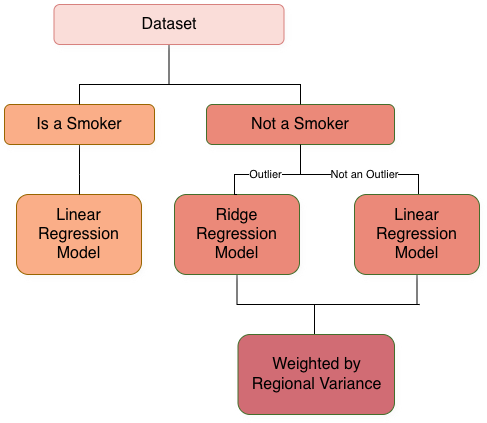

## Random Forest

In [ ]:
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = df_encoded[target_col]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Base Model ---
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# --- Parameter Grid ---
param_dist = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.2, 0.3, 0.5, 0.7, 'log2'],
    'bootstrap': [True, False],
    'criterion': ['absolute_error', 'squared_error']
}

# --- Cross-Validation Setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Randomized Search ---
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,                     # number of random combinations to test
    scoring='neg_mean_absolute_error',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- Fit Random Search ---
random_search.fit(X_train, y_train)

# --- Best Model ---
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Random Forest Hyperparameters found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# --- Cross-Validation R² for Best Model ---
cv_r2_scores = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=kf, n_jobs=-1)

# --- Evaluate on Test Set ---
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

# --- Model Metrics ---
print("\nFinal Random Forest Model Performance:")
print(f"Best CV MAE: {-random_search.best_score_:.2f}")
print(f"Mean CV R²: {np.mean(cv_r2_scores):.3f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.3f}")

# --- Feature Importance ---
feature_importance = pd.DataFrame({
    'feature': predictor_cols,
    'importance': best_model.feature_importances_ * 100
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

## Extremely Randomised Trees (Extra Trees)

In [ ]:
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = df_encoded[target_col]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Base Model ---
et = ExtraTreesRegressor(random_state=42, n_jobs=-1)

# --- Parameter Grid ---
param_dist = {
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 'log2'],
    'bootstrap': [True, False],
    'criterion': ['absolute_error', 'squared_error']
}

# --- Cross-Validation Setup ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Randomized Search ---
random_search = RandomizedSearchCV(
    estimator=et,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=kf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- Fit Random Search ---
random_search.fit(X_train, y_train)

# --- Best Model ---
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Extra Trees Hyperparameters found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# --- Cross-Validation R² for Best Model ---
cv_r2_scores = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=kf, n_jobs=-1)

# --- Evaluate on Test Set ---
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

# --- Model Metrics ---
print("\nFinal Extra Trees Model Performance:")
print(f"Best CV MAE: {-random_search.best_score_:.2f}")
print(f"Mean CV R²: {np.mean(cv_r2_scores):.3f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.3f}")

# --- Feature Importance ---
feature_importance = pd.DataFrame({
    'feature': predictor_cols,
    'importance': best_model.feature_importances_ * 100
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

## XGBoost

In [ ]:
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = df_encoded[target_col]

def run_xgboost_transform(X, y, transform='log', n_iter=50, n_splits=5):
    # --- Transform Target ---
    if transform == 'log':
        y_trans = np.log1p(y)
    elif transform == 'sqrt':
        y_trans = np.sqrt(y)
    elif transform == 'cbrt':
        y_trans = np.cbrt(y)
    elif transform == 'none':
        y_trans = y.copy()
    else:
        raise ValueError("transform must be 'log', 'sqrt', 'cbrt', or 'none'")

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)

    # --- Base XGBoost model ---
    xgb = XGBRegressor(
        objective='reg:absoluteerror',
        random_state=42,
        verbosity=0,
        n_jobs=-1
    )

    # --- Parameter Distributions ---
    param_dist = {
        'n_estimators': [100, 200, 300, 400, 500],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5],
        'min_child_weight': [1, 3, 5],
        'reg_alpha': [0, 0.1, 0.5],
        'reg_lambda': [0.5, 1.0, 1.5]
    }

    # --- Cross-Validation Setup ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- Randomized Search ---
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=kf,
        verbose=1,
        n_jobs=1,
        random_state=42
    )

    # --- Fit Random Search ---
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # --- CV Metrics ---
    cv_r2_scores = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=kf, n_jobs=1)
    cv_mae_scores = cross_val_score(best_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=kf, n_jobs=1)
    cv_mae_mean = -np.mean(cv_mae_scores)

    # Convert CV predictions back to original scale
    cv_pred_trans = cross_val_predict(best_model, X_train, y_train, cv=kf, n_jobs=1)
    if transform == 'log':
        cv_pred = np.expm1(cv_pred_trans)
        cv_true = np.expm1(y_train)
    elif transform == 'sqrt':
        cv_pred = np.power(cv_pred_trans, 2)
        cv_true = np.power(y_train, 2)
    elif transform == 'cbrt':
        cv_pred = np.power(cv_pred_trans, 3)
        cv_true = np.power(y_train, 3)
    else:
        cv_pred = cv_pred_trans
        cv_true = y_train

    cv_mae_orig = mean_absolute_error(cv_true, cv_pred)
    cv_r2_orig = r2_score(cv_true, cv_pred)

    # --- Test Set Evaluation ---
    best_model.fit(X_train, y_train)
    y_pred_trans = best_model.predict(X_test)
    if transform == 'log':
        y_pred = np.expm1(y_pred_trans)
        y_test_orig = np.expm1(y_test)
    elif transform == 'sqrt':
        y_pred = np.power(y_pred_trans, 2)
        y_test_orig = np.power(y_test, 2)
    elif transform == 'cbrt':
        y_pred = np.power(y_pred_trans, 3)
        y_test_orig = np.power(y_test, 3)
    else:
        y_pred = y_pred_trans
        y_test_orig = y_test

    test_mae = mean_absolute_error(y_test_orig, y_pred)
    test_r2 = r2_score(y_test_orig, y_pred)

    # --- Feature Importance ---
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_ * 100
    }).sort_values('importance', ascending=False)

    # --- Print Results ---
    print(f"\n=== XGBoost ({transform}) Transformation ===")
    print("Best Hyperparameters:")
    for k, v in random_search.best_params_.items():
        print(f"  {k}: {v}")
    print("\nCross-Validation Performance:")
    print(f"Mean CV MAE (transformed scale): {cv_mae_mean:.4f}")
    print(f"Mean CV R² (transformed scale): {np.mean(cv_r2_scores):.3f}")
    print(f"Mean CV MAE (original scale): {cv_mae_orig:.2f}")
    print(f"Mean CV R² (original scale): {cv_r2_orig:.3f}")
    print("\nTest Set Performance (original scale):")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test R²: {test_r2:.3f}")
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head().to_string(index=False))

    return best_model, feature_importance

In [ ]:
print("\nRegular y:")
run_xgboost_transform(X, y, transform='none', n_iter=50, n_splits=5)
print("------------------")
print("\nLog y:")
run_xgboost_transform(X, y, transform='log', n_iter=50, n_splits=5)
print("------------------")
print("\nSqrt y:")
run_xgboost_transform(X, y, transform='sqrt', n_iter=50, n_splits=5)
print("------------------")
print("\nCbrt y:")
run_xgboost_transform(X, y, transform='cbrt', n_iter=50, n_splits=5)

XGBoost results obtained from local testings:

| **Transformation** | **Best Hyperparameters** | **CV MAE (orig)** | **CV R² (orig)** | **Test MAE** | **Test R²** | **Top 5 Features** |
|---------------------|---------------------------|------------------:|----------------:|--------------:|-------------:|--------------------|
| **None** | subsample: 0.8<br>reg_lambda: 1.0<br>reg_alpha: 0.1<br>n_estimators: 500<br>min_child_weight: 5<br>max_depth: 3<br>learning_rate: 0.2<br>gamma: 0.3<br>colsample_bytree: 0.8 | 1761.53 | 0.848 | **1469.96** | **0.880** | smoker_yes (0.288)<br>age (0.166)<br>children (0.105)<br>region_southwest (0.104)<br>sex_male (0.093) |
| **Log(y)** | subsample: 0.8<br>reg_lambda: 1.0<br>reg_alpha: 0<br>n_estimators: 500<br>min_child_weight: 3<br>max_depth: 3<br>learning_rate: 0.05<br>gamma: 0<br>colsample_bytree: 1.0 | 1834.07 | 0.841 | **1560.69** | **0.869** | smoker_yes (0.276)<br>age (0.145)<br>sex_male (0.114)<br>region_southwest (0.112)<br>region_southeast (0.108) |
| **Sqrt(y)** | subsample: 0.8<br>reg_lambda: 1.0<br>reg_alpha: 0.1<br>n_estimators: 500<br>min_child_weight: 5<br>max_depth: 3<br>learning_rate: 0.2<br>gamma: 0.3<br>colsample_bytree: 0.8 | 1724.49 | 0.848 | **1529.57** | **0.877** | smoker_yes (0.334)<br>age (0.150)<br>sex_male (0.102)<br>children (0.098)<br>region_southwest (0.091) |
| **Cbrt(y)** | subsample: 0.8<br>reg_lambda: 1.0<br>reg_alpha: 0.1<br>n_estimators: 500<br>min_child_weight: 5<br>max_depth: 3<br>learning_rate: 0.2<br>gamma: 0.3<br>colsample_bytree: 0.8 | 1741.73 | 0.845 | **1443.31** | **0.879** | smoker_yes (0.316)<br>age (0.157)<br>children (0.098)<br>region_southwest (0.096)<br>sex_male (0.090) |


## Catboost

In [ ]:
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = df_encoded[target_col]

def run_catboost_transform(X, y, transform='log', n_iter=100, n_splits=5):
    # --- Transform Target ---
    if transform == 'log':
        y_trans = np.log1p(y)
    elif transform == 'sqrt':
        y_trans = np.sqrt(y)
    elif transform == 'cbrt':
        y_trans = np.cbrt(y)
    elif transform == 'none':
        y_trans = y.copy()
    else:
        raise ValueError("transform must be 'log', 'sqrt', 'cbrt', or 'none'")

    # --- Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)

    # --- Base CatBoost model ---
    cat = CatBoostRegressor(
        loss_function='MAE',
        random_seed=42,
        silent=True
    )

    # --- Parameter Distributions ---
    param_dist = {
        'iterations': [200, 400, 600, 800, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'bagging_temperature': [0, 0.5, 1, 2],
        'border_count': [32, 64, 128],
        'subsample': [0.6, 0.8, 1.0]
    }

    # --- Cross-Validation Setup ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- Randomized Search ---
    random_search = RandomizedSearchCV(
        estimator=cat,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=kf,
        verbose=1,
        n_jobs=1,
        random_state=42
    )

    # --- Fit Random Search ---
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_

    # --- CV Metrics ---
    cv_r2_scores = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=kf, n_jobs=1)
    cv_mae_scores = cross_val_score(best_model, X_train, y_train, scoring='neg_mean_absolute_error', cv=kf, n_jobs=1)
    cv_mae_mean = -np.mean(cv_mae_scores)

    cv_pred_trans = cross_val_predict(best_model, X_train, y_train, cv=kf, n_jobs=1)
    if transform == 'log':
        cv_pred = np.expm1(cv_pred_trans)
        cv_true = np.expm1(y_train)
    elif transform == 'sqrt':
        cv_pred = np.power(cv_pred_trans, 2)
        cv_true = np.power(y_train, 2)
    elif transform == 'cbrt':
        cv_pred = np.power(cv_pred_trans, 3)
        cv_true = np.power(y_train, 3)
    else:
        cv_pred = cv_pred_trans
        cv_true = y_train

    cv_mae_orig = mean_absolute_error(cv_true, cv_pred)
    cv_r2_orig = r2_score(cv_true, cv_pred)

    # --- Test Set Evaluation ---
    best_model.fit(X_train, y_train)
    y_pred_trans = best_model.predict(X_test)
    if transform == 'log':
        y_pred = np.expm1(y_pred_trans)
        y_test_orig = np.expm1(y_test)
    elif transform == 'sqrt':
        y_pred = np.power(y_pred_trans, 2)
        y_test_orig = np.power(y_test, 2)
    elif transform == 'cbrt':
        y_pred = np.power(y_pred_trans, 3)
        y_test_orig = np.power(y_test, 3)
    else:
        y_pred = y_pred_trans
        y_test_orig = y_test

    test_mae = mean_absolute_error(y_test_orig, y_pred)
    test_r2 = r2_score(y_test_orig, y_pred)

    # --- Feature Importance ---
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.get_feature_importance()
    }).sort_values('importance', ascending=False)

    # --- Print Results ---
    print(f"\n=== CatBoost ({transform}) Transformation ===")
    print("Best Hyperparameters:")
    for k, v in random_search.best_params_.items():
        print(f"  {k}: {v}")
    print("\nCross-Validation Performance:")
    print(f"Mean CV MAE (transformed scale): {cv_mae_mean:.4f}")
    print(f"Mean CV R² (transformed scale): {np.mean(cv_r2_scores):.3f}")
    print(f"Mean CV MAE (original scale): {cv_mae_orig:.2f}")
    print(f"Mean CV R² (original scale): {cv_r2_orig:.3f}")
    print("\nTest Set Performance (original scale):")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test R²: {test_r2:.3f}")
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head().to_string(index=False))

    return best_model, feature_importance

In [ ]:
print("\nRegular y:")
run_catboost_transform(X, y, transform='none', n_iter=50, n_splits=5)
print("------------------")
print("\nLog y:")
run_catboost_transform(X, y, transform='log', n_iter=50, n_splits=5)
print("------------------")
print("\nSqrt y:")
run_catboost_transform(X, y, transform='sqrt', n_iter=50, n_splits=5)
print("------------------")
print("\nCbrt y:")
run_catboost_transform(X, y, transform='cbrt', n_iter=50, n_splits=5)

In [ ]:

def run_catboost_transform_regular(X, y, transform='log', n_iter=100, n_splits=5):
    """
    Fit CatBoost on optionally transformed target and report CV + test metrics on original scale.
    Automatically detects categorical columns.
    """
    # --- Ensure object columns are converted to category ---
    X = X.copy()
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].astype('category')

    # --- Detect categorical columns for CatBoost ---
    categorical_cols = X.select_dtypes(include=['category']).columns.tolist()

    # --- Transform target ---
    if transform == 'log':
        y_trans = np.log1p(y)
    elif transform == 'sqrt':
        y_trans = np.sqrt(y)
    elif transform == 'cbrt':
        y_trans = np.cbrt(y)
    elif transform == 'none':
        y_trans = y.copy()
    else:
        raise ValueError("transform must be 'log', 'sqrt', 'cbrt', or 'none'")

    # --- Split train/test ---
    X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=42)

    # --- Base CatBoost model ---
    cat = CatBoostRegressor(
        loss_function='MAE',
        random_seed=42,
        silent=True
    )

    # --- Parameter distributions ---
    param_dist = {
        'iterations': [200, 400, 600, 800, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'bagging_temperature': [0, 0.5, 1, 2],
        'border_count': [32, 64, 128],
        'subsample': [0.6, 0.8, 1.0]
    }

    # --- Cross-validation setup ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- Randomized Search ---
    random_search = RandomizedSearchCV(
        estimator=cat,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=kf,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    # --- Fit Random Search ---
    random_search.fit(
        X_train, y_train,
        cat_features=categorical_cols
    )
    best_model = random_search.best_estimator_

    # --- Cross-validation predictions ---
    cv_pred_trans = cross_val_predict(best_model, X_train, y_train, cv=kf, n_jobs=-1)

    # --- Inverse transform predictions ---
    if transform == 'log':
        cv_pred = np.expm1(cv_pred_trans)
        cv_true = np.expm1(y_train)
    elif transform == 'sqrt':
        cv_pred = np.square(cv_pred_trans)
        cv_true = np.square(y_train)
    elif transform == 'cbrt':
        cv_pred = np.power(cv_pred_trans, 3)
        cv_true = np.power(y_train, 3)
    else:
        cv_pred = cv_pred_trans
        cv_true = y_train

    cv_mae_orig = mean_absolute_error(cv_true, cv_pred)
    cv_r2_orig = r2_score(cv_true, cv_pred)

    # --- Test set evaluation ---
    best_model.fit(X_train, y_train, cat_features=categorical_cols)
    y_pred_trans = best_model.predict(X_test)

    if transform == 'log':
        y_pred = np.expm1(y_pred_trans)
        y_test_orig = np.expm1(y_test)
    elif transform == 'sqrt':
        y_pred = np.square(y_pred_trans)
        y_test_orig = np.square(y_test)
    elif transform == 'cbrt':
        y_pred = np.power(y_pred_trans, 3)
        y_test_orig = np.power(y_test, 3)
    else:
        y_pred = y_pred_trans
        y_test_orig = y_test

    test_mae = mean_absolute_error(y_test_orig, y_pred)
    test_r2 = r2_score(y_test_orig, y_pred)

    # --- Feature importance ---
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical_cols))
    }).sort_values('importance', ascending=False)

    # --- Print results ---
    print(f"\n=== CatBoost ({transform}) Transformation ===")
    print("Best Hyperparameters:")
    for k, v in random_search.best_params_.items():
        print(f"  {k}: {v}")
    print("\nCross-Validation Performance:")
    print(f"Mean CV MAE (original scale): {cv_mae_orig:.2f}")
    print(f"Mean CV R² (original scale): {cv_r2_orig:.3f}")
    print("\nTest Set Performance (original scale):")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test R²: {test_r2:.3f}")
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head().to_string(index=False))

    return best_model, feature_importance

In [ ]:
# Using regular dataset (no one-hot encoding)
# --- Setup ---
target_col = 'charges'
predictor_cols = [col for col in df.columns if col != target_col]

X = df[predictor_cols]
y = df[target_col]

print("\nRegular y:")
run_catboost_transform_regular(X, y, transform='none', n_iter=50, n_splits=5)
print("------------------")
print("\nLog y:")
run_catboost_transform_regular(X, y, transform='log', n_iter=50, n_splits=5)
print("------------------")
print("\nSqrt y:")
run_catboost_transform_regular(X, y, transform='sqrt', n_iter=50, n_splits=5)
print("------------------")
print("\nCbrt y:")
run_catboost_transform_regular(X, y, transform='cbrt', n_iter=50, n_splits=5)

## LightGBM

In [ ]:
# --- Set up ---
predictor_cols = [col for col in df_encoded.columns if col != target_col] # LightGBM can handle both categorical and continuous data
target_col = 'charges'

X = df_encoded[predictor_cols]
y = df_encoded[target_col]

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

# --- Possible Params for Randomised Search ---
params = {
    'boosting_type': ['gbdt', 'dart'],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [4, 6, 8, -1],
    'min_child_samples': [10, 20, 50],
    'min_split_gain': [0.0, 0.01, 0.05],
    'subsample': [0.7, 0.8, 0.9],           # row sampling (bagging_fraction)
    'colsample_bytree': [0.7, 0.8, 0.9],    # feature sampling (feature_fraction)
    'reg_alpha': [0.0, 0.01, 0.1],          # L1 regularization
    'reg_lambda': [0.0, 0.1, 1.0],          # L2 regularization
    'metric': ['mae'],
    'objective': ['regression']
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Randomised Seach Params ---
random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(random_state=42, importance_type='gain', n_jobs=-1, verbose = -1),
    param_distributions= params,
    n_iter=50,
    cv = kf,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- Run Randomised Search ---
random_search.fit(X_train, y_train)

# --- Best Model ---
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best LightGBM Hyperparameters found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# --- Cross-validation R² for best model ---
cv_r2_scores = cross_val_score(best_model, X_train, y_train, scoring='r2', cv=kf, n_jobs=-1)

# --- Evaluate on test set ---
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

results = [
    {
        'CV_MAE': -random_search.best_score_,
        'CV_R2': np.mean(cv_r2_scores),
        'Test_MAE': test_mae,
        'Test_R2': test_r2
    }
]

results_df = pd.DataFrame(results)

# --- Model Metrics ---
print("\nFinal LightGBM Model Performance:")
print(f"Best CV MAE: {-random_search.best_score_:.2f}")
print(f"Mean CV R²: {np.mean(cv_r2_scores):.3f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test R²: {test_r2:.3f}")

# --- Feature Importance ---
importance_raw = best_model.feature_importances_
importance_normalised = (importance_raw / importance_raw.sum()) * 100

feature_importance = pd.DataFrame({
    'feature': predictor_cols,
    'importance': importance_normalised
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head().to_string(index=False))

# Function for Multiple Seeds

**Observation**

After running through the various models, we realised that the test set consistently performed better in our metrics across models than cross validation. It is possible that this is due to selection bias. To overcome this, we tested on different random states and took the mean and standard deviation for our metrics for a more reliable evaluation.

In [ ]:
def run_model_with_cv(X, y, model_name='catboost', transform='log', n_iter=50, n_splits=5, seed=42):
    """
    Generalized function to train and evaluate different regression models.

    Parameters:
    -----------
    X : DataFrame
        Features
    y : Series
        Target variable
    model_name : str
        Model to use: 'catboost', 'xgboost', 'lightgbm', 'randomforest',
                      'linear', 'ridge', 'lasso', 'elasticnet', 'polynomial', 'rulebased'
    transform : str
        Transformation to apply: 'log', 'sqrt', 'cbrt', or 'none'
    n_iter : int
        Number of random search iterations (ignored for basic linear regression)
    n_splits : int
        Number of CV folds
    seed : int
        Random seed for reproducibility

    Returns:
    --------
    model : trained model (or dict for rule-based)
    feature_importance : DataFrame
    train_cv_mae : float
    train_cv_r2 : float
    test_mae : float
    test_r2 : float
    """

    # --- Split train/test FIRST on original target ---
    X_train, X_test, y_train_orig, y_test_orig = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    # --- Transform target AFTER splitting ---
    if transform == 'log':
        y_train = np.log1p(y_train_orig)
        y_test = np.log1p(y_test_orig)
    elif transform == 'sqrt':
        y_train = np.sqrt(y_train_orig)
        y_test = np.sqrt(y_test_orig)
    elif transform == 'cbrt':
        y_train = np.cbrt(y_train_orig)
        y_test = np.cbrt(y_test_orig)
    elif transform == 'none':
        y_train = y_train_orig.copy()
        y_test = y_test_orig.copy()
    else:
        raise ValueError("transform must be 'log', 'sqrt', 'cbrt', or 'none'")

    # --- Select model and parameter distributions ---
    model_name_lower = model_name.lower()

    # --- Tree-based models ---
    if model_name_lower == 'catboost':
        base_model = CatBoostRegressor(
            loss_function='MAE',
            random_seed=seed,
            verbose=False
        )
        param_dist = {
            'iterations': [200, 400, 600, 800, 1000],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'depth': [4, 6, 8, 10],
            'l2_leaf_reg': [1, 3, 5, 7, 9],
            'bagging_temperature': [0, 0.5, 1, 2],
            'border_count': [32, 64, 128],
            'subsample': [0.6, 0.8, 1.0]
        }
        use_random_search = True

    elif model_name_lower == 'xgboost':
        base_model = XGBRegressor(
            objective='reg:absoluteerror',
            random_state=seed,
            verbosity=0
        )
        param_dist = {
            'n_estimators': [200, 400, 600, 800, 1000],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [4, 6, 8, 10],
            'reg_alpha': [0, 0.1, 1, 10],
            'reg_lambda': [1, 3, 5, 7, 9],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'min_child_weight': [1, 3, 5]
        }
        use_random_search = True

    elif model_name_lower == 'lightgbm':
        base_model = LGBMRegressor(
            objective='mae',
            random_state=seed,
            verbose=-1
        )
        param_dist = {
            'n_estimators': [200, 400, 600, 800, 1000],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'max_depth': [4, 6, 8, 10, -1],
            'num_leaves': [31, 63, 127, 255],
            'reg_alpha': [0, 0.1, 1, 10],
            'reg_lambda': [0, 0.1, 1, 10],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'min_child_samples': [5, 10, 20]
        }
        use_random_search = True

    elif model_name_lower == 'randomforest':
        base_model = RandomForestRegressor(
            random_state=seed,
            n_jobs=1
        )
        param_dist = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', 0.4, 0.5, 0.6],
            'bootstrap': [True, False],
            'criterion': ['absolute_error', 'squared_error']
        }
        use_random_search = True

    elif model_name_lower == 'extratrees':
        base_model = ExtraTreesRegressor(
            random_state=seed,
            n_jobs=1
        )
        param_dist = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10, 16],
            'min_samples_leaf': [2, 4, 8],
            'max_features': [0.3, 0.5, 0.7, 0.8, 0.9, 'log2'],
            'bootstrap': [True, False],
            'criterion': ['absolute_error', 'squared_error']
    }
        use_random_search = True

    # --- Linear models ---
    elif model_name_lower == 'linear':
        base_model = LinearRegression()
        param_dist = {}
        use_random_search = False

    elif model_name_lower == 'ridge':
        base_model = Ridge(random_state=seed)
        param_dist = {
            'alpha': np.logspace(-3, 3, 50)
        }
        use_random_search = True

    elif model_name_lower == 'lasso':
        base_model = Lasso(random_state=seed, max_iter=10000)
        param_dist = {
            'alpha': np.logspace(-4, 1, 50)
        }
        use_random_search = True

    elif model_name_lower == 'elasticnet':
        base_model = ElasticNet(random_state=seed, max_iter=10000)
        param_dist = {
            'alpha': np.logspace(-4, 1, 30),
            'l1_ratio': np.linspace(0.1, 0.9, 20)
        }
        use_random_search = True

    elif model_name_lower == 'polynomial':
        # Apply polynomial features
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_train_poly = pd.DataFrame(
            poly.fit_transform(X_train),
            columns=poly.get_feature_names_out(X_train.columns)
        )
        X_test_poly = pd.DataFrame(
            poly.transform(X_test),
            columns=poly.get_feature_names_out(X_train.columns)
        )
        X_train = X_train_poly
        X_test = X_test_poly

        base_model = LinearRegression()
        param_dist = {}
        use_random_search = False

    elif model_name_lower == 'rulebased':
        return _run_rulebased_model(X_train, X_test, y_train_orig, y_test_orig,
                                    transform, n_splits, seed)

    else:
        raise ValueError(f"model_name '{model_name}' not recognized")

    # --- Cross-validation setup ---
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # --- Fit model with or without hyperparameter tuning ---
    if use_random_search and param_dist:
        random_search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_dist,
            n_iter=n_iter,
            scoring='neg_mean_absolute_error',
            cv=kf,
            verbose=1,
            n_jobs=-1,
            random_state=seed
        )
        print(f"Fitting RandomizedSearchCV for {model_name.upper()} with {n_iter} iterations...")
        random_search.fit(X_train, y_train)
        best_model = random_search.best_estimator_
        best_cv_score_transformed = -random_search.best_score_

        print(f"\nBest Hyperparameters:")
        for k, v in random_search.best_params_.items():
            print(f"  {k}: {v}")
    else:
        print(f"Fitting {model_name.upper()}...")
        best_model = base_model
        best_model.fit(X_train, y_train)
        best_cv_score_transformed = None

    # --- Get train CV predictions on original scale ---
    cv_pred_trans = cross_val_predict(best_model, X_train, y_train, cv=kf, n_jobs=1)

    if transform == 'log':
        cv_pred = np.expm1(cv_pred_trans)
    elif transform == 'sqrt':
        cv_pred = np.power(cv_pred_trans, 2)
    elif transform == 'cbrt':
        cv_pred = np.power(cv_pred_trans, 3)
    else:
        cv_pred = cv_pred_trans

    train_cv_mae = mean_absolute_error(y_train_orig, cv_pred)
    train_cv_r2 = r2_score(y_train_orig, cv_pred)

    # --- Test set evaluation ---
    y_pred_trans = best_model.predict(X_test)
    if transform == 'log':
        y_pred = np.expm1(y_pred_trans)
    elif transform == 'sqrt':
        y_pred = np.power(y_pred_trans, 2)
    elif transform == 'cbrt':
        y_pred = np.power(y_pred_trans, 3)
    else:
        y_pred = y_pred_trans

    test_mae = mean_absolute_error(y_test_orig, y_pred)
    test_r2 = r2_score(y_test_orig, y_pred)

    # --- Feature importance ---
    try:
        if model_name_lower == 'catboost':
            importances = best_model.get_feature_importance()
        elif model_name_lower in ['xgboost', 'lightgbm', 'randomforest', 'extratrees']:
            importances = best_model.feature_importances_
        elif model_name_lower in ['linear', 'ridge', 'lasso', 'elasticnet', 'polynomial']:
            importances = np.abs(best_model.coef_)
        else:
            importances = None

        if importances is not None:
            feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': importances
            }).sort_values('importance', ascending=False)
        else:
            feature_importance = pd.DataFrame()
    except:
        feature_importance = pd.DataFrame()

    # --- Print results ---
    print(f"\n=== {model_name.upper()} ({transform} transformation, seed={seed}) ===")
    if best_cv_score_transformed is not None:
        print(f"\nCV Performance During Tuning (transformed scale):")
        print(f"  Best CV MAE: {best_cv_score_transformed:.4f}")
    print(f"\nTrain CV Performance (original scale):")
    print(f"  Train CV MAE: {train_cv_mae:.2f}")
    print(f"  Train CV R²: {train_cv_r2:.3f}")
    print(f"\nTest Set Performance (original scale):")
    print(f"  Test MAE: {test_mae:.2f}")
    print(f"  Test R²: {test_r2:.3f}")
    print(f"\nOverfitting Check:")
    print(f"  MAE Gap (Test - Train CV): {test_mae - train_cv_mae:.2f}")
    print(f"  R² Gap (Test - Train CV): {test_r2 - train_cv_r2:.3f}")

    if not feature_importance.empty:
        print("\nTop 5 Most Important Features:")
        print(feature_importance.head().to_string(index=False))

    return best_model, feature_importance, train_cv_mae, train_cv_r2, test_mae, test_r2


def _run_rulebased_model(X_train, X_test, y_train_orig, y_test_orig, transform, n_splits, seed):
    """
    Rule-based model: separate models for smokers and non-smokers.
    """
    # Prepare dataframes
    train_df = X_train.copy()
    train_df['charges'] = y_train_orig.values
    test_df = X_test.copy()
    test_df['charges'] = y_test_orig.values

    # --- Check if smoker_yes exists ---
    if 'smoker_yes' not in train_df.columns:
        raise ValueError("Rule-based model requires 'smoker_yes' column")

    # --- Split by smoker status ---
    train_smokers = train_df[train_df['smoker_yes'] == 1].copy()
    test_smokers = test_df[test_df['smoker_yes'] == 1].copy()
    train_nonsmokers = train_df[train_df['smoker_yes'] == 0].copy()
    test_nonsmokers = test_df[test_df['smoker_yes'] == 0].copy()

    cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

    # --- Smokers Model: Simple features ---
    for df_ in [train_smokers, test_smokers]:
        if 'bmi' in df_.columns:
            df_['bmi_over30'] = (df_['bmi'] > 30).astype(int)

    smok_features = ['age', 'bmi_over30'] if 'age' in train_smokers.columns else ['bmi_over30']
    X_smok_train = train_smokers[smok_features]
    y_smok_train = train_smokers['charges']
    X_smok_test = test_smokers[smok_features]
    y_smok_test = test_smokers['charges']

    lm_smok = LinearRegression()
    lm_smok.fit(X_smok_train, y_smok_train)
    y_smok_pred = lm_smok.predict(X_smok_test)

    # --- Non-Smokers Model: Feature engineering ---
    def feature_engineering(df):
        if 'age' in df.columns and 'bmi' in df.columns:
            df['age_bmi'] = df['age'] * df['bmi']
        if 'age' in df.columns and 'children' in df.columns:
            df['age_children'] = df['age'] * df['children']
        if 'bmi' in df.columns and 'children' in df.columns:
            df['bmi_children'] = df['bmi'] * df['children']
        if 'age' in df.columns:
            df['age2'] = df['age'] ** 2
        if 'bmi' in df.columns:
            df['bmi2'] = df['bmi'] ** 2
        return df

    for df_ in [train_nonsmokers, test_nonsmokers]:
        feature_engineering(df_)

    # --- Ridge for non-smokers ---
    X_nonsmok_train = train_nonsmokers.drop(columns=['charges', 'smoker_yes'])
    y_nonsmok_train = train_nonsmokers['charges']
    X_nonsmok_test = test_nonsmokers.drop(columns=['charges', 'smoker_yes'])
    y_nonsmok_test = test_nonsmokers['charges']

    ridge_nonsmok = Ridge(alpha=1.0, random_state=seed)
    ridge_nonsmok.fit(X_nonsmok_train, y_nonsmok_train)
    y_nonsmok_pred = ridge_nonsmok.predict(X_nonsmok_test)

    # --- Combined predictions ---
    y_test_combined = pd.concat([y_smok_test, y_nonsmok_test])
    y_pred_combined = np.concatenate([y_smok_pred, y_nonsmok_pred])

    # --- Calculate metrics ---
    test_mae = mean_absolute_error(y_test_combined, y_pred_combined)
    test_r2 = r2_score(y_test_combined, y_pred_combined)

    # --- CV performance (approximate using full training sets) ---
    y_train_combined = pd.concat([y_smok_train, y_nonsmok_train])
    y_pred_train_smok = lm_smok.predict(X_smok_train)
    y_pred_train_nonsmok = ridge_nonsmok.predict(X_nonsmok_train)
    y_pred_train_combined = np.concatenate([y_pred_train_smok, y_pred_train_nonsmok])

    train_cv_mae = mean_absolute_error(y_train_combined, y_pred_train_combined)
    train_cv_r2 = r2_score(y_train_combined, y_pred_train_combined)

    # --- Store models ---
    models = {
        'smoker_model': lm_smok,
        'nonsmoker_model': ridge_nonsmok
    }

    feature_importance = pd.DataFrame()

    print(f"\n=== RULEBASED (seed={seed}) ===")
    print(f"\nTrain CV Performance (original scale):")
    print(f"  Train CV MAE: {train_cv_mae:.2f}")
    print(f"  Train CV R²: {train_cv_r2:.3f}")
    print(f"\nTest Set Performance (original scale):")
    print(f"  Test MAE: {test_mae:.2f}")
    print(f"  Test R²: {test_r2:.3f}")
    print(f"\nOverfitting Check:")
    print(f"  MAE Gap (Test - Train CV): {test_mae - train_cv_mae:.2f}")
    print(f"  R² Gap (Test - Train CV): {test_r2 - train_cv_r2:.3f}")

    return models, feature_importance, train_cv_mae, train_cv_r2, test_mae, test_r2


def run_multiple_seeds(X, y, model_name='catboost', transform='log', n_iter=50, n_splits=5,
                       seeds=[42, 123, 456, 789, 999]):
    """
    Run the model with multiple random seeds to assess performance stability.
    """
    results = []

    for seed in seeds:
        print(f"\n{'='*60}")
        print(f"Running {model_name.upper()} with seed={seed}")
        print(f"{'='*60}")

        model, feat_imp, train_cv_mae, train_cv_r2, test_mae, test_r2 = run_model_with_cv(
            X, y, model_name=model_name, transform=transform, n_iter=n_iter,
            n_splits=n_splits, seed=seed
        )

        results.append({
            'seed': seed,
            'train_cv_mae': train_cv_mae,
            'train_cv_r2': train_cv_r2,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'mae_gap': test_mae - train_cv_mae,
            'r2_gap': test_r2 - train_cv_r2
        })

    # --- Summary Statistics ---
    results_df = pd.DataFrame(results)
    print(f"\n{'='*60}")
    print(f"SUMMARY FOR {model_name.upper()} ACROSS {len(seeds)} SEEDS")
    print(f"{'='*60}")
    print(f"\nMAE Performance:")
    print(f"  Train CV MAE: {results_df['train_cv_mae'].mean():.2f} ± {results_df['train_cv_mae'].std():.2f}")
    print(f"  Test MAE:     {results_df['test_mae'].mean():.2f} ± {results_df['test_mae'].std():.2f}")
    print(f"  MAE Gap:      {results_df['mae_gap'].mean():.2f} ± {results_df['mae_gap'].std():.2f}")

    print(f"\nR² Performance:")
    print(f"  Train CV R²:  {results_df['train_cv_r2'].mean():.3f} ± {results_df['train_cv_r2'].std():.3f}")
    print(f"  Test R²:      {results_df['test_r2'].mean():.3f} ± {results_df['test_r2'].std():.3f}")
    print(f"  R² Gap:       {results_df['r2_gap'].mean():.3f} ± {results_df['r2_gap'].std():.3f}")

    print(f"\nCoefficient of Variation:")
    print(f"  Train CV MAE CV: {results_df['train_cv_mae'].std() / results_df['train_cv_mae'].mean() * 100:.1f}%")
    print(f"  Test MAE CV:     {results_df['test_mae'].std() / results_df['test_mae'].mean() * 100:.1f}%")

    print("\nDetailed Results:")
    print(results_df.to_string(index=False))

    return results_df


def compare_models(X, y, models=['catboost', 'xgboost', 'lightgbm', 'randomforest'],
                   transform='log', n_iter=20, n_splits=5, seeds=[42, 123, 456]):
    """
    Compare multiple models across different seeds.

    Returns a summary DataFrame comparing all models.
    """
    comparison_results = []

    for model_name in models:
        print(f"\n{'#'*60}")
        print(f"# EVALUATING {model_name.upper()}")
        print(f"{'#'*60}")

        try:
            results_df = run_multiple_seeds(
                X, y, model_name=model_name, transform=transform,
                n_iter=n_iter, n_splits=n_splits, seeds=seeds
            )

            comparison_results.append({
                'Model': model_name.upper(),
                'Train CV MAE': f"{results_df['train_cv_mae'].mean():.2f} ± {results_df['train_cv_mae'].std():.2f}",
                'Test MAE': f"{results_df['test_mae'].mean():.2f} ± {results_df['test_mae'].std():.2f}",
                'Test R²': f"{results_df['test_r2'].mean():.3f} ± {results_df['test_r2'].std():.3f}",
                'MAE Gap': f"{results_df['mae_gap'].mean():.2f}",
                'test_mae_mean': results_df['test_mae'].mean()  # For sorting
            })
        except Exception as e:
            print(f"Error running {model_name}: {e}")

    # --- Create comparison DataFrame ---
    comparison_df = pd.DataFrame(comparison_results)
    comparison_df = comparison_df.sort_values('test_mae_mean')
    comparison_df = comparison_df.drop(columns=['test_mae_mean'])  # Remove sorting column

    print(f"\n{'='*80}")
    print(f"MODEL COMPARISON SUMMARY (Ranked by Test MAE)")
    print(f"{'='*80}")
    print(comparison_df.to_string(index=False))

    return comparison_df


# ============================================================================
# USAGE EXAMPLES
# ============================================================================

"""
# Example 1: Single linear model, single seed
model, feat_imp, train_mae, train_r2, test_mae, test_r2 = run_model_with_cv(
    X, y,
    model_name='ridge',
    transform='log',
    n_iter=50,
    seed=42
)

# Example 2: Polynomial regression with multiple seeds
results = run_multiple_seeds(
    X, y,
    model_name='polynomial',
    transform='log',
    n_iter=20,
    seeds=[42, 123, 456, 789, 999]
)

# Example 3: Compare all models (tree-based + linear)
comparison = compare_models(
    X, y,
    models=['linear', 'ridge', 'lasso', 'elasticnet', 'polynomial',
            'catboost', 'xgboost', 'lightgbm', 'randomforest', 'rulebased'],
    transform='log',
    n_iter=20,
    seeds=[42, 123, 456]
)

# Example 4: Compare only linear models
comparison_linear = compare_models(
    X, y,
    models=['linear', 'ridge', 'lasso', 'elasticnet', 'polynomial'],
    transform='log',
    n_iter=20,
    seeds=[42, 123, 456, 789, 999]
)
"""

In [ ]:
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]

X = df_encoded[predictor_cols]
y = df_encoded[target_col]

comparison = compare_models(
    X, y,
    models = ['linear', 'ridge', 'lasso', 'elasticnet', 'polynomial',
              'catboost', 'xgboost', 'lightgbm', 'randomforest', 'extratrees', 'rulebased'],
    transform = 'none',
    n_iter = 50,  # Check hyperparameter combinations
    seeds = [42, 123, 456, 789, 999]
)

**Observation**

After running through 5 different seeds, the test set still performs better than the cross validation. We will run some statistical checks to figure out why.

In [ ]:
target_col = 'charges'
predictor_cols = [col for col in df_encoded.columns if col != target_col]
X = df_encoded[predictor_cols]
y = df_encoded[target_col]

seeds = [42, 123, 456, 789, 999]
results_summary = []

# Analyze each seed
for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=seed
    )

    # Calculate statistics
    results_summary.append({
        'Seed': seed,
        'Train_Mean': y_train.mean(),
        'Train_Std': y_train.std(),
        'Train_Min': y_train.min(),
        'Train_Max': y_train.max(),
        'Train_Q99': y_train.quantile(0.99),
        'Train_Outliers': (y_train > y_train.quantile(0.99)).sum(),
        'Test_Mean': y_test.mean(),
        'Test_Std': y_test.std(),
        'Test_Min': y_test.min(),
        'Test_Max': y_test.max(),
        'Test_Q99': y_test.quantile(0.99),
        'Test_Outliers': (y_test > y_test.quantile(0.99)).sum(),
        'Mean_Diff': y_test.mean() - y_train.mean(),
        'Std_Diff': y_test.std() - y_train.std()
    })

# Create summary DataFrame
summary_df = pd.DataFrame(results_summary)

print("="*80)
print("DISTRIBUTION COMPARISON ACROSS 5 SEEDS")
print("="*80)
print("\nTrain vs Test Statistics:")
print(summary_df[['Seed', 'Train_Mean', 'Test_Mean', 'Mean_Diff',
                  'Train_Std', 'Test_Std', 'Std_Diff']].to_string(index=False))

print("\n" + "="*80)
print("Outlier Analysis:")
print("="*80)
print(summary_df[['Seed', 'Train_Outliers', 'Test_Outliers',
                  'Train_Max', 'Test_Max']].to_string(index=False))

print("\n" + "="*80)
print("OVERALL SUMMARY:")
print("="*80)
print(f"Average Train Mean: ${summary_df['Train_Mean'].mean():.2f} ± ${summary_df['Train_Mean'].std():.2f}")
print(f"Average Test Mean:  ${summary_df['Test_Mean'].mean():.2f} ± ${summary_df['Test_Mean'].std():.2f}")
print(f"\nAverage Mean Difference (Test - Train): ${summary_df['Mean_Diff'].mean():.2f}")
print(f"Range of Mean Differences: ${summary_df['Mean_Diff'].min():.2f} to ${summary_df['Mean_Diff'].max():.2f}")

**Observation**

From the statistics, we deduced that the better performance in the test set vs the validation set is likely because the model trains on the whole training set before predicting on the test set. Because more data points are used in training than in validation, with a small dataset, this improvement in generalisation is significant. This accounts for why test MAE is consistently lower.

# Result Summary

This analysis compares 11 different regression models for predicting medical insurance charges using a dataset of 1,338 patients with demographic and lifestyle features. All models were evaluated across 5 different random seeds to assess performance stability.

---

## 📊 Final Model Rankings (by Test MAE)

| Rank | Model | Test MAE | Test R² | Stability (CV%) |
|------|-------|----------|---------|-----------------|
| **1** | **CATBOOST** | **$1,405 ± $229** | 0.870 | 16.3% |
| **2** | **LIGHTGBM** | **$1,472 ± $235** | 0.870 | 16.0% |
| **3** | **XGBOOST** | **$1,548 ± $204** | 0.868 | 13.2% |
| 4 | EXTRATREES | $1,612 ± $217 | 0.870 | 13.5% |
| 5 | RANDOMFOREST | $1,646 ± $167 | 0.870 | 10.2% |
| 6 | RULEBASED | $2,394 ± $142 | 0.878 | 5.9% |
| 7 | LINEAR | $2,792 ± $203 | 0.853 | 7.3% |
| 8 | LASSO | $2,793 ± $200 | 0.853 | 7.2% |
| 9 | RIDGE | $2,793 ± $200 | 0.853 | 7.2% |
| 10 | ELASTICNET | $2,795 ± $200 | 0.853 | 7.2% |
| 11 | POLYNOMIAL | $2,850 ± $180 | 0.835 | 6.3% |

---

## 📈 Performance Across Seeds

**Key Finding:** Test performance is consistently better than CV across all seeds due to training on 25% more data (1,070 vs 856 samples).
